### The purpose of this notebook to is to recreate the regress the SSH in GLORYS onto the CWI developed in Amaya et al. (2022)

In [2]:
import os
os.chdir('/vortexfs1/home/anthony.meza/Atmospheric Rivers and Waves/scripts')
plotsdir = lambda x="": "/vortexfs1/home/anthony.meza/Atmospheric Rivers and Waves/plots/" + x
GLORYS_dir = lambda x="": "/vortexfs1/texfs1/home/anthony.meza/GLORYS_data" + x
GLORYS_data_dir = lambda x="": "/vortexfs1/home/anthony.meza/Atmospheric Rivers and Waves/GLORYS_processed/" + x
ERA5_data_dir = lambda x="": "/vortexfs1/home/anthony.meza/Atmospheric Rivers and Waves/ERA5_data/" + x

In [3]:
import numpy as np
import xarray as xr
from pathlib import Path
import matplotlib.pyplot as plt
import gc
import os 
from os.path import exists
from scipy import signal
import copy
from scipy.signal.windows import tukey
from scipy import linalg
from scipy.fft import fft2, ifft2, fftfreq, fftshift, fft, rfft2, irfft2, ifftshift
import pickle
import datetime
import seaborn as sns 

In [4]:
colors = [sns.color_palette("tab10")[i] for i in [4, 3, 0]]

In [5]:
#will plot relevant locations to a line plot
normalize = lambda x: (x - np.mean(x)) / np.std(x)
def plot_geovlines(labels_dict, ax):
    ax2 = ax.twiny()
    locs=[]
    labels = []
    ylims = ax.get_ylim()
    for (key, value) in labels_dict.items():
        ax2.axvline(value, c = "grey")
        locs+=[value]
        labels+=[key]
    ax2.set_xticklabels(labels)
    ax2.set_xticks(locs)
    ax2.set_xlim(ax.get_xlim()[0], ax.get_xlim()[1])
def extract_EOFs(u, var_spacing, varnames):
    EOFs_dict = {}
    for (i, varname) in enumerate(varnames):
        EOFs_dict[varname] = {}
        for j in range(0, 2):
            EOFs_dict[varname]["EOF" + str(j+1)] = u[i*var_spacing:(i+1)*var_spacing, j];
    return EOFs_dict
def extract_normalized_PCs(u, Y):
    PC_dict = {}
    for i in range(0, 2):
        U = u[:, i:i+1];
        PC_dict["PC"+str(i+1)] = normalize(U.T @ Y).flatten() #get expansion coefs for first EOF
    return PC_dict
def index_amplitude(PC_dict):
    return np.sqrt(PC_dict["PC1"]**2 + PC_dict["PC2"]**2)

### Reading in the GLORYS and ERA5 data files. Files have been preprocessed and combined in order to take advantage of the **dask** feature of xarray. We also remove their seasonal cliamtologies

In [6]:
anomalies = xr.open_dataset(GLORYS_data_dir("GLORYS_Coastal_Vars_Anomalies.nc"))
anomalies_filtered = xr.open_dataset(GLORYS_data_dir("GLORYS_Coastal_Vars_Anomalies_bandpass.nc"))
anomalies_filtered_kandf = xr.open_dataset(GLORYS_data_dir("GLORYS_Coastal_Vars_Anomalies_bandpassandwavenumber.nc"))
hovmoller_ds = xr.open_dataset(GLORYS_data_dir("GLORYS_Coastal_Path.nc")).compute()
coast_vars = xr.open_dataset(GLORYS_data_dir("GLORYS_Coastal_Vars.nc")).compute()

coords_pth = "/vortexfs1/share/cdx/hseo/Data/MERCATOR/GLO-MFC_001_030_coordinates.nc"
coords = xr.open_dataset(coords_pth).sel(latitude = slice(-2, 60), longitude = slice(-150, -75) )

In [7]:
distances = hovmoller_ds.distance.values
findminlat = lambda lat, lat0: np.argmin((lat - lat0)**2)

In [8]:
distance_labels = {}
distance_labels["SA"] = np.max(hovmoller_ds.EQ.values * distances)
distance_labels["GC W"] = distances[hovmoller_ds.GC_C.values.astype("bool")].mean()
distance_labels["GC E"] = distances[hovmoller_ds.GC_E.values.astype("bool")].max() - (distance_labels["GC W"] - distances[hovmoller_ds.GC_C.values.astype("bool")].min())
distance_labels["LA"] = distances[findminlat(hovmoller_ds.lat_path.values, 33)]
distance_labels["SF"] = distances[findminlat(hovmoller_ds.lat_path.values, 38)]
# Store data (serialize)
with open(GLORYS_data_dir("GLORYS_CoastalLocations.pickle"), 'wb') as handle:
    pickle.dump(distance_labels, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
for (key, value) in distance_labels.items():
    print(key, value)

SA 8057.143034818774
GC W 15143.821818490203
GC E 13909.775670258205
LA 17256.65712028268
SF 18167.188007624824


In [33]:
#zero out the equator, only keep coastal points 
coast_mask = anomalies_filtered_kandf.distance
coast_mask = (coast_mask > distance_labels["SA"]).astype("int").values

### Apply the eof to the filtered data 

In [1]:
#mask the data 
filtered = anomalies_filtered_kandf.load()
filtered_masked = filtered.isel(distance = np.where(coast_mask)[0])

#normalize the data
pf = filtered_masked.polyfit(dim = "time", deg=1, skipna = False)
trends = xr.polyval(filtered_masked.time, pf)
filtered_trends = trends.rename({"thetao_polyfit_coefficients":"thetao", "zos_polyfit_coefficients":"zos"})
filtered = (filtered - filtered_trends) #remove linear trends from all variables 
filtered_std = filtered.std(dim = "time").mean(dim = "distance") #spatial mean
filtered = filtered 
filtered = filtered.compute()

NameError: name 'anomalies_filtered_kandf' is not defined

In [ ]:
#SSH and Mixed Layer
ds_standardized = np.concatenate([filtered.zos.values.T, 
                           filtered.thetao.isel(depth = 0).values.T,
                           filtered.thetao.isel(depth = 1).values.T,
                          filtered.thetao.isel(depth = 2).values.T])

Y_SSHandMxLyer = np.array([a.flatten() for a in ds_standardized]) #Y is space x time
SVD_SSHandMxLyer  = linalg.svd(Y_SSHandMxLyer, full_matrices= False) #do svd 

#Mixed Layer
ds_standardized = np.concatenate([filtered.thetao.isel(depth = 0).values.T,
                           filtered.thetao.isel(depth = 1).values.T,
                          filtered.thetao.isel(depth = 2).values.T])

Y_MxLyer = np.array([a.flatten() for a in ds_standardized]) #Y is space x time
SVD_MxLyer = linalg.svd(Y_MxLyer, full_matrices= False) #do svd 

Y_SSH = filtered.zos.values.T
SVD_SSH = linalg.svd(Y_SSH, full_matrices= False) #do svd 

In [38]:
#plot different
var_spacing = len(filtered_masked.distance) #each of has the length of distance

(u, s, vh) = SVD_SSHandMxLyer
EOFs_SM = extract_EOFs(u, var_spacing, ["SSH", "SST", "5mtemp", "18mtemp"]) 
PCs_SM = extract_normalized_PCs(u, Y_SSHandMxLyer) 

(u, s, vh) = SVD_MxLyer
EOFs_M = extract_EOFs(u, var_spacing, ["SST", "5mtemp", "18mtemp"]) 
PCs_M = extract_normalized_PCs(u, Y_MxLyer) 

(u, s, vh) = SVD_SSH
EOFs_S = extract_EOFs(u, var_spacing, ["SSH"]) 
PCs_S = extract_normalized_PCs(u, Y_SSH) 

index_labels = ["SSH and Mixed Layer Temp. Coastal Wave Index", "Mixed Layer Temp. Coastal Wave Index", "SSH Coastal Wave Index"]

In [73]:
xdistances = filtered_masked.distance.values
xdistances = xdistances - xdistances[0]
xdistance_labels = {k:v -distance_labels["SA"]  for k, v in distance_labels.items()}

/tmp/ipykernel_373768/3799177208.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(labels)


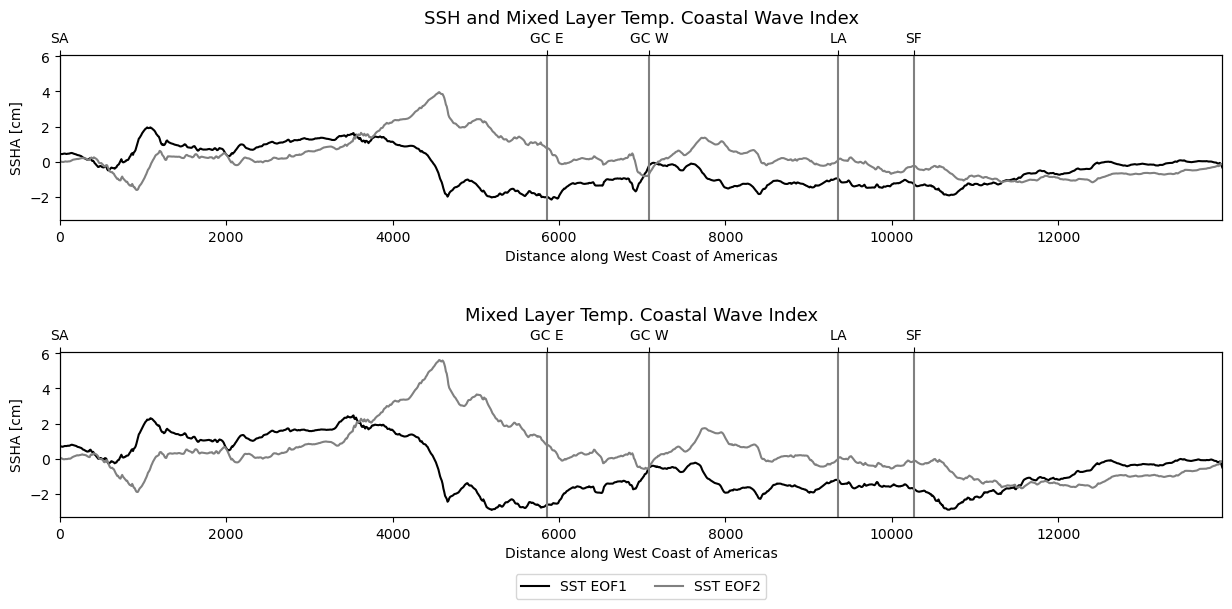

In [76]:

fig1, ax = plt.subplots(2, 1, figsize = (15, 6), sharey = True)

ax[0].set_title("SSH and Mixed Layer Temp. Coastal Wave Index", fontsize = 13)
ax[1].set_title("Mixed Layer Temp. Coastal Wave Index", fontsize = 13)


cs = ["black", "grey"]
flip_sign1 = [1, -1]
flip_sign2 = [-1, 1]
for (i, eof) in enumerate(["EOF1", "EOF2"]):
    ax[0].plot(xdistances, 100 * EOFs_SM["SST"][eof] * flip_sign1[i], c = cs[i])
    ax[1].plot(xdistances, 100 * EOFs_M["SST"][eof] * flip_sign2[i], c = cs[i], label = "SST " + eof)

ax[1].legend()
[a.set_xlabel("Distance along West Coast of Americas") for a in ax]
[a.set_ylabel("SSHA [cm]") for a in ax]
[a.set_xlim(xdistances.min(), xdistances.max()) for a in ax]
ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.3),
          ncol=2)
fig1.subplots_adjust(hspace = 0.8)

plot_geovlines(xdistance_labels, ax[0])
plot_geovlines(xdistance_labels, ax[1])

/tmp/ipykernel_373768/3799177208.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(labels)


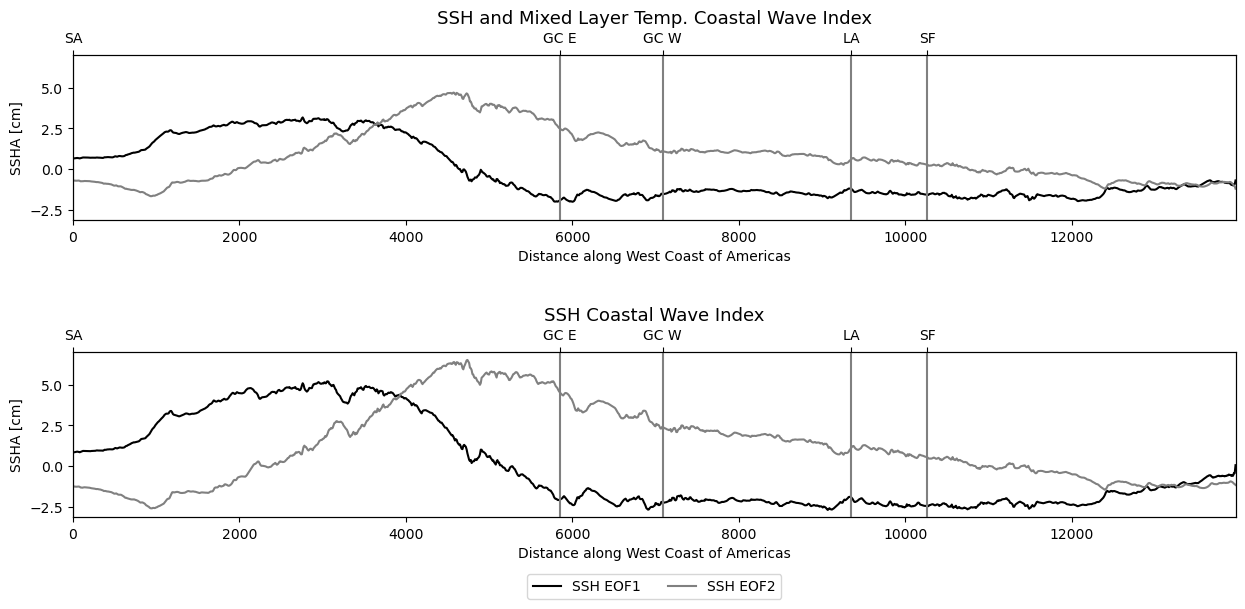

In [78]:
fig1, ax = plt.subplots(2, 1, figsize = (15, 6), sharey = True)

ax[0].set_title("SSH and Mixed Layer Temp. Coastal Wave Index", fontsize = 13)
ax[1].set_title("SSH Coastal Wave Index", fontsize = 13)


cs = ["black", "grey"]
flip_sign1 = [1, -1]
flip_sign2 = [-1, 1]
for (i, eof) in enumerate(["EOF1", "EOF2"]):
    ax[0].plot(xdistances, 100 * EOFs_SM["SSH"][eof] * flip_sign1[i], c = cs[i])
    ax[1].plot(xdistances, 100 * EOFs_S["SSH"][eof] * flip_sign2[i], c = cs[i], label = "SSH " + eof)

ax[1].legend()
[a.set_xlabel("Distance along West Coast of Americas") for a in ax]
[a.set_ylabel("SSHA [cm]") for a in ax]
[a.set_xlim(xdistances.min(), xdistances.max()) for a in ax]
ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.3),
          ncol=2)
fig1.subplots_adjust(hspace = 0.8)
plot_geovlines(xdistance_labels, ax[0])
plot_geovlines(xdistance_labels, ax[1])

/tmp/ipykernel_373768/1953267584.py:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(range(1, len(perc_var)+1), 100 * perc_var, label = "SSH and Mixed Layer Temp. Coastal Wave Index", c = colors[0])
/tmp/ipykernel_373768/1953267584.py:10: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(range(1, len(perc_var)+1), 100 * perc_var, label = "Mixed Layer Temp. Coastal Wave Index", c = colors[1])
/tmp/ipykernel_

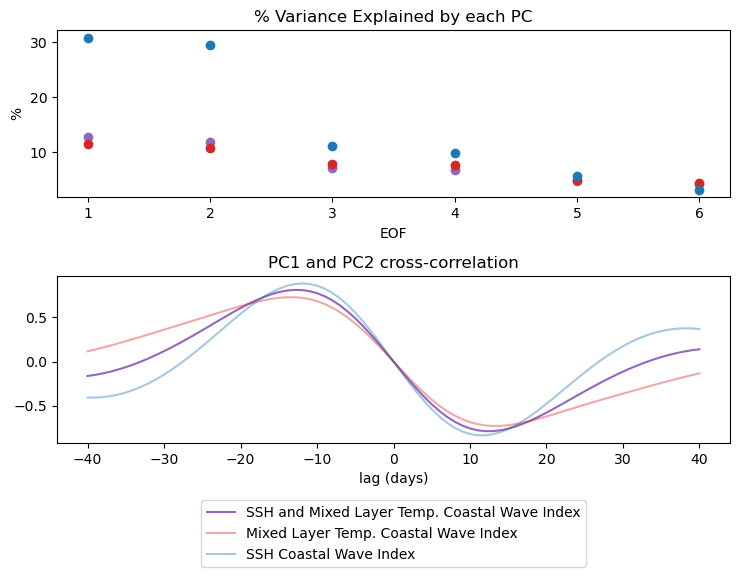

In [79]:
#plot the variance explained by each PC 

fig, axes = plt.subplots(2, 1, figsize = (7.5,6));
ax = axes[0]
(u, s, vh) = SVD_SSHandMxLyer
perc_var = np.array([lam**2 / np.sum(s**2) for lam in s[0:6]])
ax.scatter(range(1, len(perc_var)+1), 100 * perc_var, label = "SSH and Mixed Layer Temp. Coastal Wave Index", c = colors[0])
(u, s, vh) = SVD_MxLyer
perc_var = np.array([lam**2 / np.sum(s**2) for lam in s[0:6]])
ax.scatter(range(1, len(perc_var)+1), 100 * perc_var, label = "Mixed Layer Temp. Coastal Wave Index", c = colors[1])
(u, s, vh) = SVD_SSH
perc_var = np.array([lam**2 / np.sum(s**2) for lam in s[0:6]])
ax.scatter(range(1, len(perc_var)+1), 100 * perc_var, label = "SSH Coastal Wave Index", c = colors[2])
ax.set_title("% Variance Explained by each PC")
ax.set_xlabel("EOF"); ax.set_ylabel("%"); 

#Plot the cross correlation
ax = axes[1]
PCs = [PCs_SM, PCs_M, PCs_S]
flip_PC1 = [1,-1, -1]
flip_PC2 = [-1,1, 1]
alphas = [1, 0.4, 0.4]
for (i, PC) in enumerate(PCs):
    output = ax.xcorr(PC["PC1"] * flip_PC1[i], PC["PC2"] * flip_PC2[i], maxlags=40, usevlines = False, normed=True, alpha=0.0)
    ax.plot(output[0], output[1], label = index_labels[i], c = colors[i], alpha = alphas[i])
ax.legend()
ax.set_title("PC1 and PC2 cross-correlation")
ax.set_xlabel("lag (days)")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3),
          ncol=1)
fig.tight_layout()

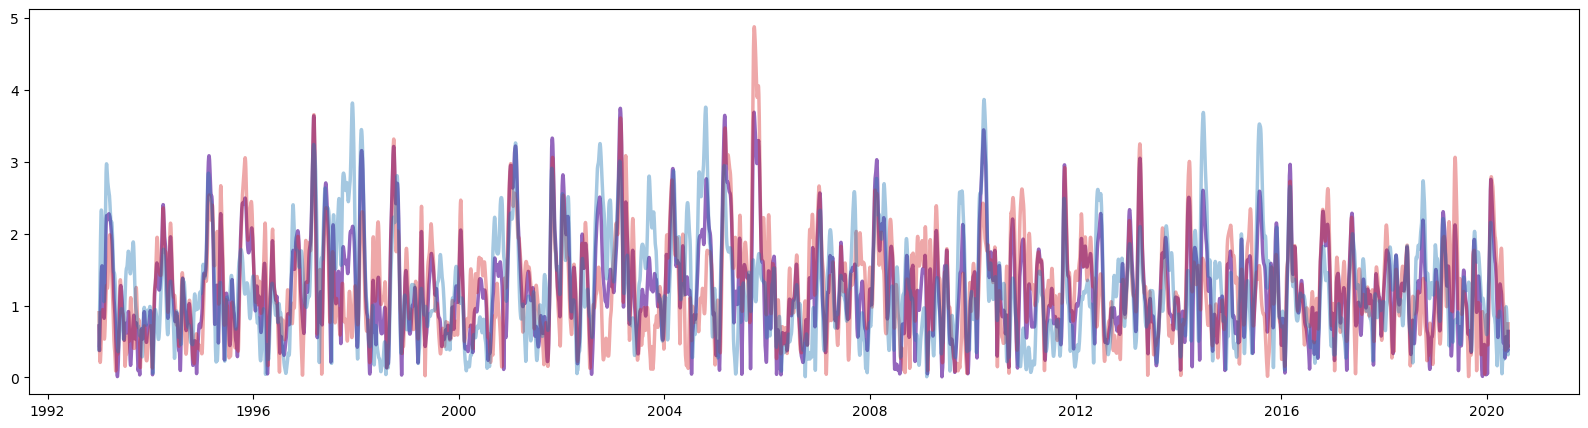

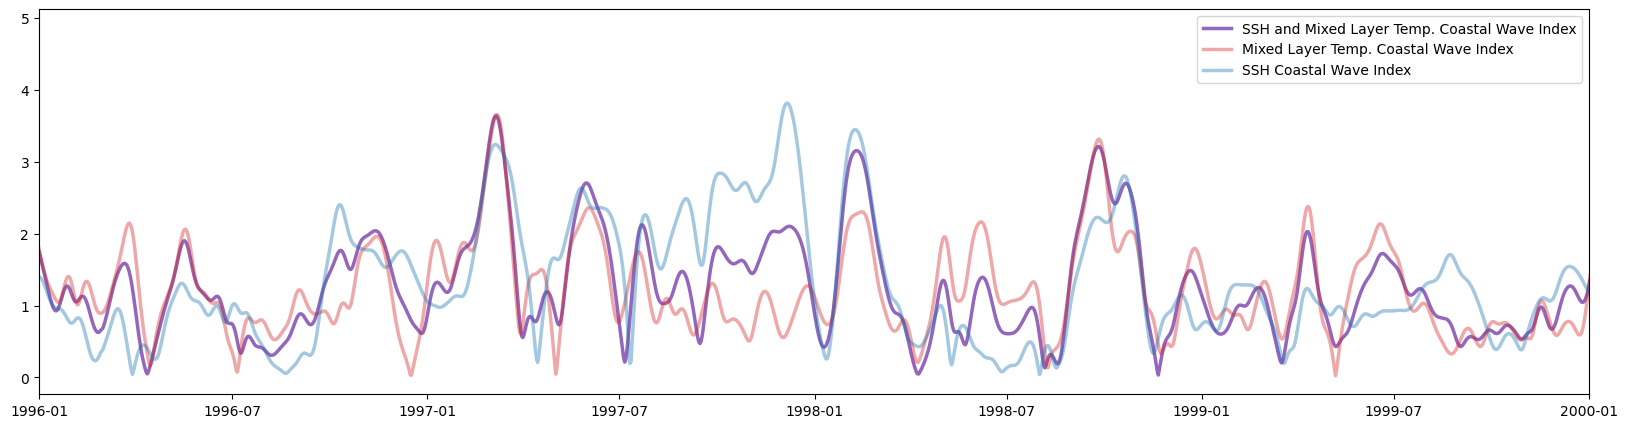

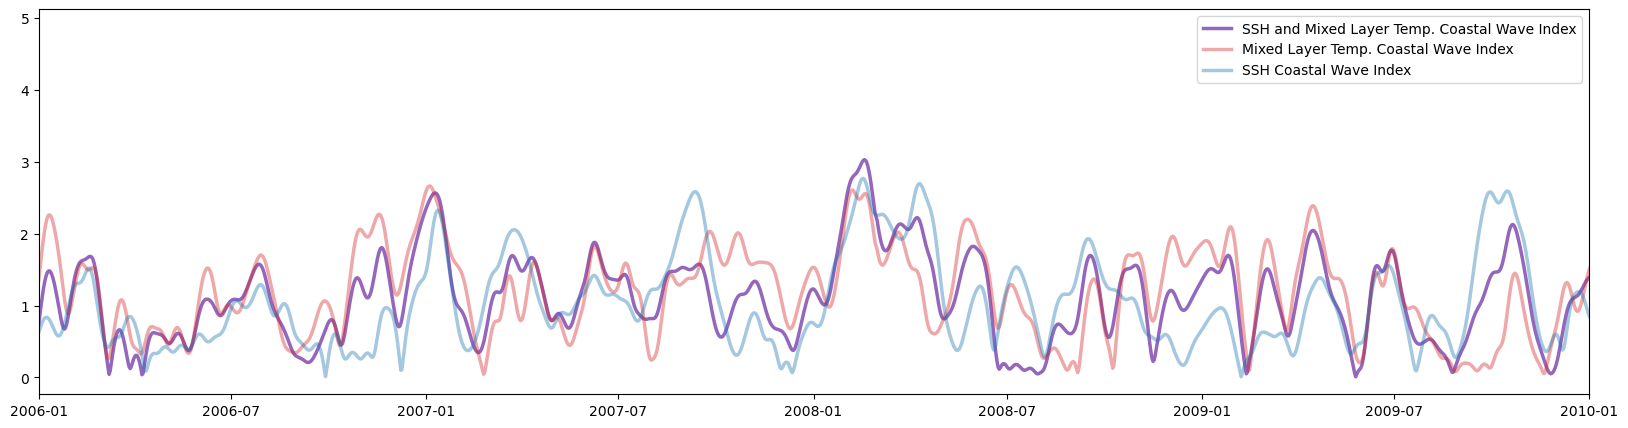

In [63]:
xtime = anomalies_filtered_kandf.time.values

fig, ax = plt.subplots(figsize = (20, 5))
lws = [2.5, 2.5, 2.5]; alphas = [1, 0.4, 0.4]
for (i, PC) in enumerate(PCs):
    ax.plot(xtime, index_amplitude(PC), label = index_labels[i], c = colors[i], linewidth = lws[i], alpha = alphas[i])

# ax.legend()
fig, ax = plt.subplots(figsize = (20, 5))
for (i, PC) in enumerate(PCs):
    ax.plot(xtime, index_amplitude(PC), label = index_labels[i], c = colors[i], linewidth = lws[i], alpha = alphas[i])
ax.set_xlim([datetime.date(1996, 1, 1), datetime.date(2000, 1, 1)])
ax.legend()

# ax.legend()
fig, ax = plt.subplots(figsize = (20, 5))
for (i, PC) in enumerate(PCs):
    ax.plot(xtime, index_amplitude(PC), label = index_labels[i], c = colors[i], linewidth = lws[i], alpha = alphas[i])
ax.set_xlim([datetime.date(2006, 1, 1), datetime.date(2010, 1, 1)])
ax.legend()

In [80]:
(u, s, vh) = SVD_SSHandMxLyer
EOFs_SM = extract_EOFs(u, var_spacing, ["SSH", "SST", "5mtemp", "18mtemp"]) 
PCs_SM = extract_normalized_PCs(u, Y_SSHandMxLyer) 

(u, s, vh) = SVD_MxLyer
EOFs_M = extract_EOFs(u, var_spacing, ["SST", "5mtemp", "18mtemp"]) 
PCs_M = extract_normalized_PCs(u, Y_MxLyer) 

(u, s, vh) = SVD_SSH
EOFs_S = extract_EOFs(u, var_spacing, ["SSH"]) 
PCs_S = extract_normalized_PCs(u, Y_SSH) 

In [81]:
import copy 
PC_labels = ["SSH and Mixed Layer Temp. EOF", "Mixed Layer Temp. EOF", "SSH EOF"]
fnames = ["GLORYS_SM_Index.nc", "GLORYS_M_Index.nc", "GLORYS_S_Index.nc"]
for (i, PC) in enumerate(PCs):
    ds = copy.deepcopy(anomalies_filtered_kandf)
    ds['PC1'] = (('time'), PC["PC1"] * flip_PC1[i])
    ds['PC2'] = (('time'), PC["PC2"] * flip_PC2[i])
    ds['PC1'].attrs = {"description":"normalized PC1 of " + PC_labels[i]}
    ds['PC2'].attrs = {"description":"normalized PC2 of " + PC_labels[i]}
    print("saving file")
    ds.to_netcdf(GLORYS_data_dir(fnames[i]),
                 mode = "w", format = "NETCDF4", 
                 engine = "netcdf4", compute = True)

saving file
saving file
saving file


In [82]:
EOFs = [EOFs_SM, EOFs_M, EOFs_S]
fnames = ["GLORYS_SM_EOFs.pickle", "GLORYS_M_EOFs.pickle", "GLORYS_S_EOFs.pickle"]

for (i, eof) in enumerate(EOFs):
    for key in eof.keys():
        eof[key]["EOF1"] *= flip_PC1[i]
        eof[key]["EOF2"] *= flip_PC2[i]
    eof["distance"] = xdistances
    # Store data (serialize)
    with open(GLORYS_data_dir(fnames[i]), 'wb') as handle:
        pickle.dump(distance_labels, handle, protocol=pickle.HIGHEST_PROTOCOL)